# PhyloTreeViz

Katrina Kalantar
February 23, 2017

#### Playground for developing scripts to plot complex phylogenetic trees relating multiple alignments and their ancestors



Script does the following:

1. Sets up the plotting libraries
2. Imports a .lca file (output from running phylowalk_m8parser.py)
3. Parses the .lca file to generate a tree and associated visual properties
4. Outputs the tree to a .pdf 


In [9]:
import ete3
from ete3 import NCBITaxa
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from ete3 import Tree
from collections import Counter
from ete3 import TreeStyle, add_face_to_node, TextFace, PieChartFace, COLOR_SCHEMES, faces, NodeStyle
import matplotlib.colors
import numpy as np

% matplotlib inline

In [10]:
# initialize the NCBI database
ncbi = NCBITaxa()   # this will create taxdump.tar.gz in the current directory, 
                    # takes many minutes to run the first time but is required for ete3 to 
                    # access phylogenetic relationships

### Read in some .lca output
This is currently set-up to work with .m8.lca files that result from running phylowalk_m8parser.py on a gsnap multi-alignment .m8 file

**TODO:** Expand this to work with .sam.lca files from phylowalk_SAMparser.py

In [11]:
df = pd.read_csv("./data/retained-NR.retained-NT.filter.unmapped.cdhit.ZINTER_FUNG_CFUS_250_RNA.1000.m8.lca",sep='\t')  # did this sample have lots of neisseria??
df.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,raw_gi,tax_id,0,LCA,LCAclass,LCAname
0,NR:374927:NT:71421:K00153:419:HL2C2BBXX:5:1108...,gi|148715293|gb|CP000671.1|,98.4,126,2,0,1,126,771544,771669,1.700000e-72,281.4,148715293,374930.0,"374931,281310,71421,374930",727.0,species,Haemophilus influenzae
1,NR:374927:NT:71421:K00153:419:HL2C2BBXX:5:1108...,gi|148717999|gb|CP000672.1|,98.4,126,2,0,1,126,354556,354431,1.700000e-72,281.4,148717999,374931.0,"374931,281310,71421,374930",727.0,species,Haemophilus influenzae
2,NR:374927:NT:71421:K00153:419:HL2C2BBXX:5:1108...,gi|156617157|gb|CP000057.2|,98.4,126,2,0,1,126,1810080,1809955,1.700000e-72,281.4,156617157,281310.0,"374931,281310,71421,374930",727.0,species,Haemophilus influenzae
3,NR:374927:NT:71421:K00153:419:HL2C2BBXX:5:1108...,gi|6626252|gb|L42023.1|,98.4,126,2,0,1,126,1728450,1728325,1.700000e-72,281.4,6626252,71421.0,"374931,281310,71421,374930",727.0,species,Haemophilus influenzae
4,NR:374927:NT:71421:K00153:419:HL2C2BBXX:5:1108...,gi|6626252|gb|L42023.1|,96.8,126,4,0,1,126,1728285,1728410,9.500000e-70,272.3,6626252,71421.0,71421,71421.0,species,Haemophilus influenzae Rd KW20


In [28]:
# set up for color-mapping by bitscore
rgba_colors = plt.cm.jet(np.linspace(0,1,300))
hex_colors = [matplotlib.colors.rgb2hex(item[:3]) for item in rgba_colors.tolist()] # array of 300 hex colors 
                                                                                    # increasing from blue to red

### Testing out the Bar Chart Functionality

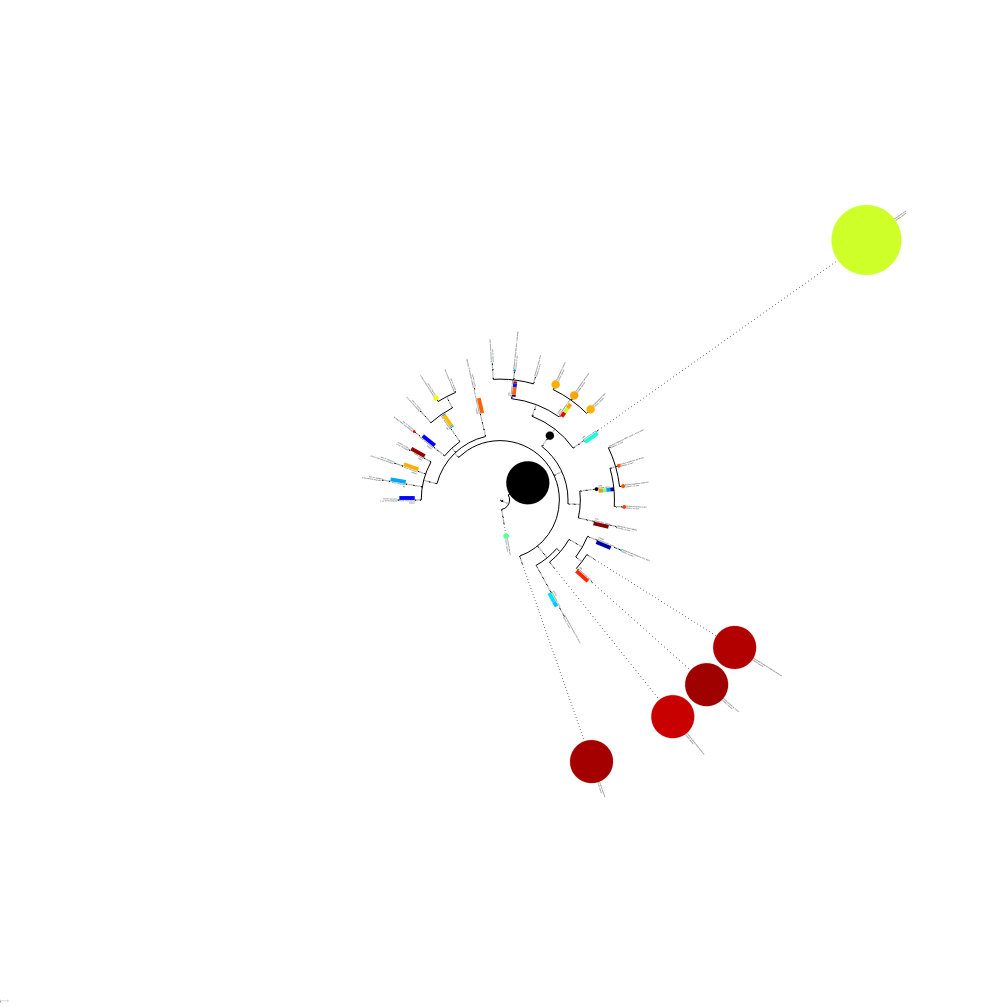

In [44]:
# create a dictionary and add the # of occurrences of that taxid everytime you hit a taxid again
# ... this will be the size of the point. 
# then calculate the mean (and variance) in bitscore for that taxID...this will be the point color

dict_of_taxid_counts = {}

df[['0','LCA','LCAclass']].drop_duplicates()  # we want to take only unique taxID/LCA combos to limit computation
df2 = df[['0','LCA','LCAclass']]

# this DataFrame contains [ taxID list / LCA / LCA class / # of times this set occurs ]
df3 = df2.groupby(df2.columns.tolist(), as_index=False).size()  

bs_df = df[['bitscore','tax_id']]  # isloate the bitscores and taxIDs
bs_df_mean = bs_df.groupby('tax_id', as_index=False).mean() # get the mean bitscore for each taxID
bs_df_var = bs_df.groupby('tax_id', as_index=False).var() # get the variance in bitscore for each taxID

# this function is called when plotting to tree to add complex Faces objects to each node
def layout(node):    
    
    # if this is a leaf node, report full name, taxID, and rank
    if node.is_leaf():
        
        longNameFace = faces.TextFace(node.sci_name + "\n" + str(node.taxid) + "; " + node.rank)
        faces.add_face_to_node(longNameFace,node,column=1)
        
    else:
        
        try:            # check if this internal node was in the list of taxIDs (as in subspecies:species)
            dict_of_taxid_counts[str(n.taxid)]
            longNameFace = faces.TextFace(node.sci_name + "\n" + str(node.taxid) + "; " + node.rank)
            faces.add_face_to_node(longNameFace,node,column=1)
            
        except:        # not in list, this is a filler node from NCBI tree so just put shorthand notation of taxid
            longNameFace = faces.TextFace(str(node.taxid))
            faces.add_face_to_node(longNameFace,node,column=1)
            
        # if the internal node was an LCA then set the color = BLACK and size = # of times this LCA appeared  
        if node.taxid in list_of_lca:
            node.img_style["fgcolor"] = 'black'
            node.img_style["size"] = lca_counts[node.taxid]#/100
        
        
        # compute the proportions for every genus-level node - 
        # this visually represents evenness of species-level calls within a genus
        proportions = {}
        if(node.rank =="genus"):      #or node.taxid in list_of_lca): <-- note, adding this increases computational time substantially
            longNameFace = faces.TextFace(node.sci_name + "; " + node.rank)
            faces.add_face_to_node(longNameFace,node,column=1)
            for n in node.traverse(): 
                
                try:
                    proportions[n.sci_name] = dict_of_taxid_counts[str(n.taxid)]
                    
                except:
                    continue # the taxID doesn't seem to exist in the ete3 taxon tree...SKIP for now. 
                    # TODO: add some other functionality here beyond just ignoring it? 
                  
            ser = pd.Series(proportions)
            props = list((ser/ser.sum())*100)
            names = ser.index
            
            # create the stacked barchart FACE object, add to each genus-level object
            barchartFace = faces.StackedBarFace(props, width=100, height=25, colors = 
                                                random.sample(hex_colors,len(props)))
            faces.add_face_to_node(barchartFace,node,column=1)
        


list_of_lca = []
lca_counts = {}

for i in range(len(df3.head(n=20))):     # loop through the dataframe of unique taxID/LCA pairs
    
    number_of_occurences = df3[i]        # get the number of occurences of this taxID/LCA pair
    taxids = df3.index[i][0].split(',')
    lca = df3.index[i][1]
    lcaclass = df3.index[i][2]
    
    # keep a count of the number of times an LCA was observed
    list_of_lca.append(lca)
    try:
        lca_counts[lca] += number_of_occurences
    except:
        lca_counts[lca] = number_of_occurences
    
    # keep a count of the number of times each taxID was observed
    for t in taxids:
        if t != "None":
            try:
                dict_of_taxid_counts[t] += number_of_occurences
            except:
                dict_of_taxid_counts[t] = number_of_occurences
    
    if lca not in taxids:
        try:
            dict_of_taxid_counts[str(int(lca))] += number_of_occurences
        except:
            dict_of_taxid_counts[str(int(lca))] = number_of_occurences

#print(len(dict_of_taxid_counts))
#print(pd.Series(dict_of_taxid_counts))

# this was added to avoid an error with invalid key = '1642824' (likely just bc it isn't in the ete3 taxonomic DB)
tree_input = [i for i in dict_of_taxid_counts.keys() if i != '1642824' ]  

# including intermediate nodes to ensure tree is balanced
tree = ncbi.get_topology(tree_input, intermediate_nodes=True)  


# set up the output tree style
ts = TreeStyle()
ts.layout_fn = layout          # invoke layout fn above to generate complex Face objects for nodes
ts.show_leaf_name = False
ts.mode = 'c'                  # circular tree
ts.arc_start = -180
ts.arc_span = 270
ts.draw_guiding_lines = False
ts.scale = 10

#print(max(dict_of_taxid_counts.values()))

for n in tree.traverse():      # loop through all nodes in the tree
    nstyle = NodeStyle()       # set the node style

    try:
        size =  dict_of_taxid_counts[str(n.taxid)]#/100     # size corresponds to number of occurrences
        
        # color corresponds to mean bitscore
        color = hex_colors[int(np.round(bs_df_mean[bs_df_mean['tax_id']==n.taxid]['bitscore'].iloc[0]))]
        
    except:
        color = 'gray'   # if the taxid wasn't a true alignment, but rather a filler node then make it small, grey
        size = 1
       
    nstyle["fgcolor"] = color
    nstyle["size"] = size
    n.set_style(nstyle)
        
tree.render(file_name = "%%inline", w=1000, tree_style=ts)        # render to the jupyter notebook
#tree.render(file_name = "something.pdf", w=1000, tree_style=ts)  # save to .pdf (allows zooming)

In [34]:
print(tree.get_ascii(attributes=['sci_name', 'taxid']))


                                                                                                        /Alcaligenaceae, 506Pusillimonas, 305976-Pusillimonas sp. T7-7, 1007105
                                                                                                       |
                                                                                                       |-unclassified Burkholderiales, 119065Burkholderiales Genera incertae sedis, 224471Leptothrix, 88Leptothrix cholodnii, 34029-Leptothrix cholodnii SP-6, 395495
                                                         /Betaproteobacteria, 28216Burkholderiales, 80840
                                                        |                                              |-Oxalobacteraceae, 75682Collimonas, 202907Collimonas fungivorans, 158899-Collimonas fungivorans Ter331, 1005048
                                                        |                                              |
                             

### Previous iterations

These code chunks are intended for exploring simpler graph iterations and keeping track of progress.

In [38]:
# MOST basic - just testing out ASCII tree of two related species
tree = ncbi.get_topology(['858451','1550730'])#, intermediate_nodes=True)
print(tree.get_ascii(attributes=['sci_name', 'taxid']))


                                             /-Rhizobacter profundi, 1550730
-Burkholderiales Genera incertae sedis, 224471
                                             \-Rubrivivax sp. JA309, 858451


### Very basic layout, but still incoporating some information regarding leaf/internal node status.

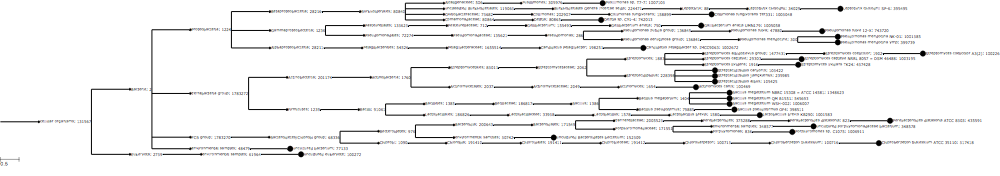

In [45]:
def layout(node):    
    if node.is_leaf():
        longNameFace = faces.TextFace(node.sci_name + "; " + str(node.taxid))
        faces.add_face_to_node(longNameFace,node,column=1)
    else :
        longNameFace = faces.TextFace(node.sci_name + "; " + str(node.taxid))
        faces.add_face_to_node(longNameFace,node,column=1)
        node.img_style["size"] = 6

ts = TreeStyle()
ts.layout_fn = layout
ts.show_leaf_name = False
#ts.mode = 'c'
#ts.arc_start = -180
#ts.arc_span = 180
ts.draw_guiding_lines = False
ts.scale = 100

for n in tree.traverse():
    nstyle = NodeStyle()

    try:
        print(taxid_bitscore_map[str(n.taxid)])
        color = hex_colors[taxid_bitscore_map[str(n.taxid)]]
        
    except:
        color = 'black'
       
    nstyle["fgcolor"] = color
    nstyle["size"] = 15
    n.set_style(nstyle)
        
tree.render(file_name = "%%inline", w=1000, tree_style=ts)

### More advanced layout; color by mean bitscore, size by number of occurrences

37


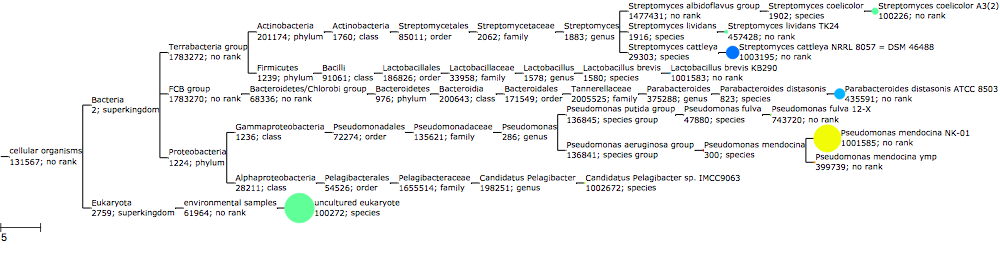

In [46]:

# create a dictionary and add one everytime you hit a taxid again - this will be the size. 
# then calculate the mean (and variance) in bitscore for that taxID...could plot this as a histogram.
dict_of_taxid_counts = {}

df[['0','LCA','LCAclass']].drop_duplicates()
df2 = df[['0','LCA','LCAclass']]
df3 = df2.groupby(df2.columns.tolist(), as_index=False).size()

bs_df = df[['bitscore','tax_id']]
bs_df_mean = bs_df.groupby('tax_id', as_index=False).mean() # this is the mean bitscore for each taxID
bs_df_var = bs_df.groupby('tax_id', as_index=False).var() # this is the mean bitscore for each taxID


def layout(node):    
    if node.is_leaf():
        longNameFace = faces.TextFace(node.sci_name + "\n" + str(node.taxid) + "; " + node.rank)
        faces.add_face_to_node(longNameFace,node,column=1)
    else :
        longNameFace = faces.TextFace(node.sci_name + "\n" + str(node.taxid) + "; " + node.rank)
        faces.add_face_to_node(longNameFace,node,column=1)


for i in range(len(df3.head(n=10))):
    
    
    number_of_occurences = df3[i]
    taxids = df3.index[i][0].split(',')
    lca = df3.index[i][1]
    lcaclass = df3.index[i][2]
    
    for t in taxids:
        if t != "None":
            try:
                dict_of_taxid_counts[t] += number_of_occurences
            except:
                dict_of_taxid_counts[t] = number_of_occurences
    
    if lca not in taxids:
        try:
            dict_of_taxid_counts[str(int(lca))] += number_of_occurences
        except:
            dict_of_taxid_counts[str(int(lca))] = number_of_occurences

tree_input = [i for i in dict_of_taxid_counts.keys() if i != '1642824' ]
tree = ncbi.get_topology(tree_input, intermediate_nodes=True)#dict_of_taxid_counts.keys())


ts = TreeStyle()
ts.layout_fn = layout
ts.show_leaf_name = False
#ts.mode = 'c'
#ts.arc_start = -180
#ts.arc_span = 270
ts.draw_guiding_lines = False
ts.scale = 10

print(max(dict_of_taxid_counts.values()))

for n in tree.traverse():
    nstyle = NodeStyle()

    try:
        size =  dict_of_taxid_counts[str(n.taxid)]#/100
        #print("AHHHH: " + str(int(np.round(bs_df_mean[bs_df_mean['tax_id']==n.taxid]['bitscore'].iloc[0]))))
        color = hex_colors[int(np.round(bs_df_mean[bs_df_mean['tax_id']==n.taxid]['bitscore'].iloc[0]))]
        
    except:# Exception as e:
        #print(e)
        color = 'gray'
        size = 1
       
    nstyle["fgcolor"] = color
    nstyle["size"] = size
    n.set_style(nstyle)


        
tree.render(file_name = "%%inline", w=1000, tree_style=ts)
#tree.render(file_name = "something.pdf", w=5000, tree_style=ts)